In [150]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/store_time_series/
!ls


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/store_time_series
catboost_info  submission.csv  test.csv  train.csv


In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [264]:
#loading data
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')


In [6]:
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [ ]:
train_df.nunique()

,0
id,3000888
date,1684
store_nbr,54
family,33
sales,379610
onpromotion,362


In [ ]:
train_df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [ ]:
train_df.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0


In [ ]:
train_df.duplicated().sum()

0

In [4]:
count_zero_sales = (train_df['sales'] == 0).sum()
print(count_zero_sales)

939130


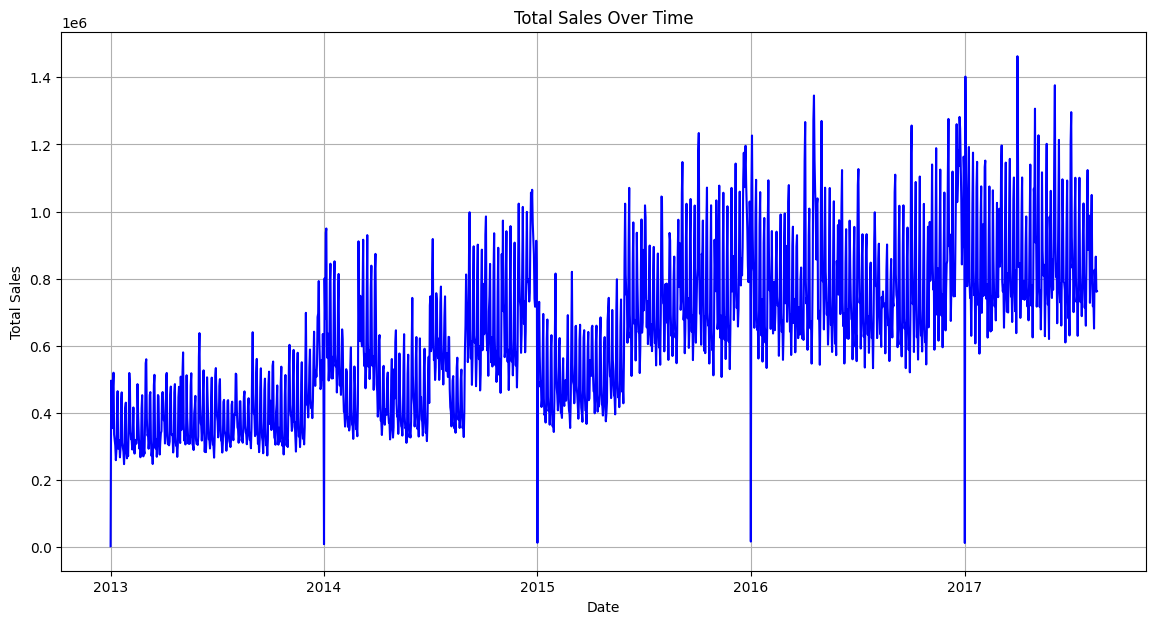

In [ ]:
# Group the data by 'date' and calculate the total sales for each date
total_sales_by_date = final_merged_data.groupby('date')['sales'].sum()

# Plot the total sales over time
plt.figure(figsize=(14, 7))
plt.plot(total_sales_by_date.index, total_sales_by_date.values, color='blue')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

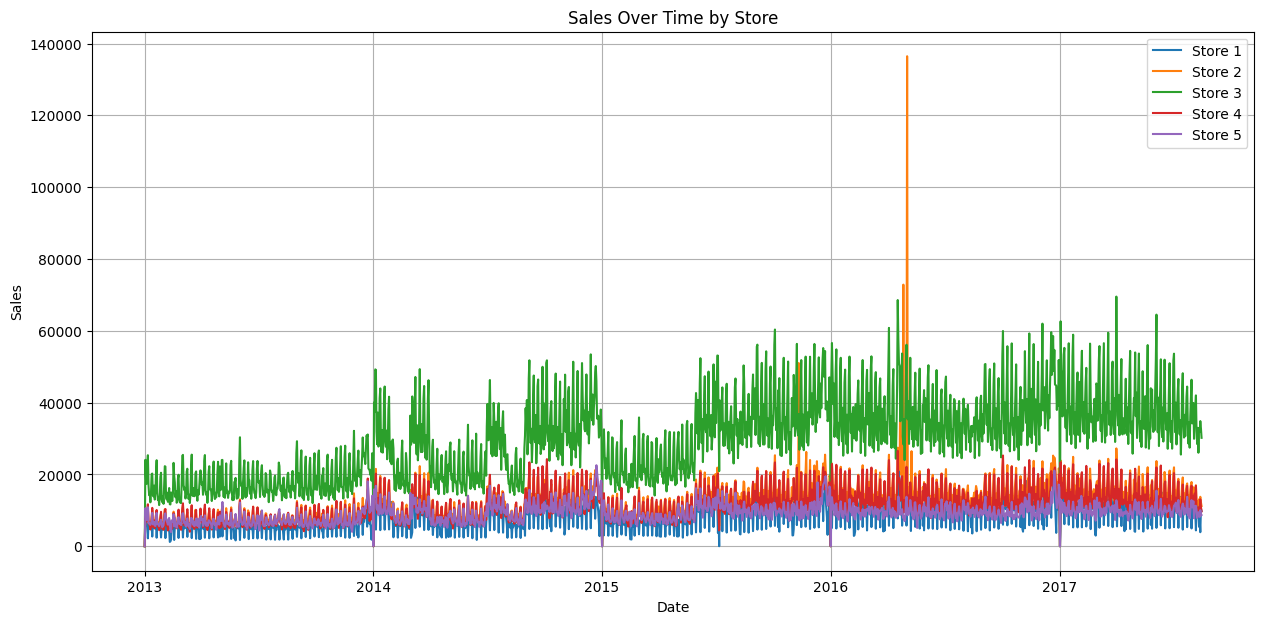

In [ ]:
# Group by 'date' and 'store_nbr' and sum the sales
sales_by_store_time = final_merged_data.groupby(['date', 'store_nbr'])['sales'].sum().reset_index()

# Plot sales for a few stores
plt.figure(figsize=(15, 7))
for store in sales_by_store_time['store_nbr'].unique()[:5]:  # Plot for the first 5 stores
    store_data = sales_by_store_time[sales_by_store_time['store_nbr'] == store]
    plt.plot(store_data['date'], store_data['sales'], label=f'Store {store}')

plt.title('Sales Over Time by Store')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


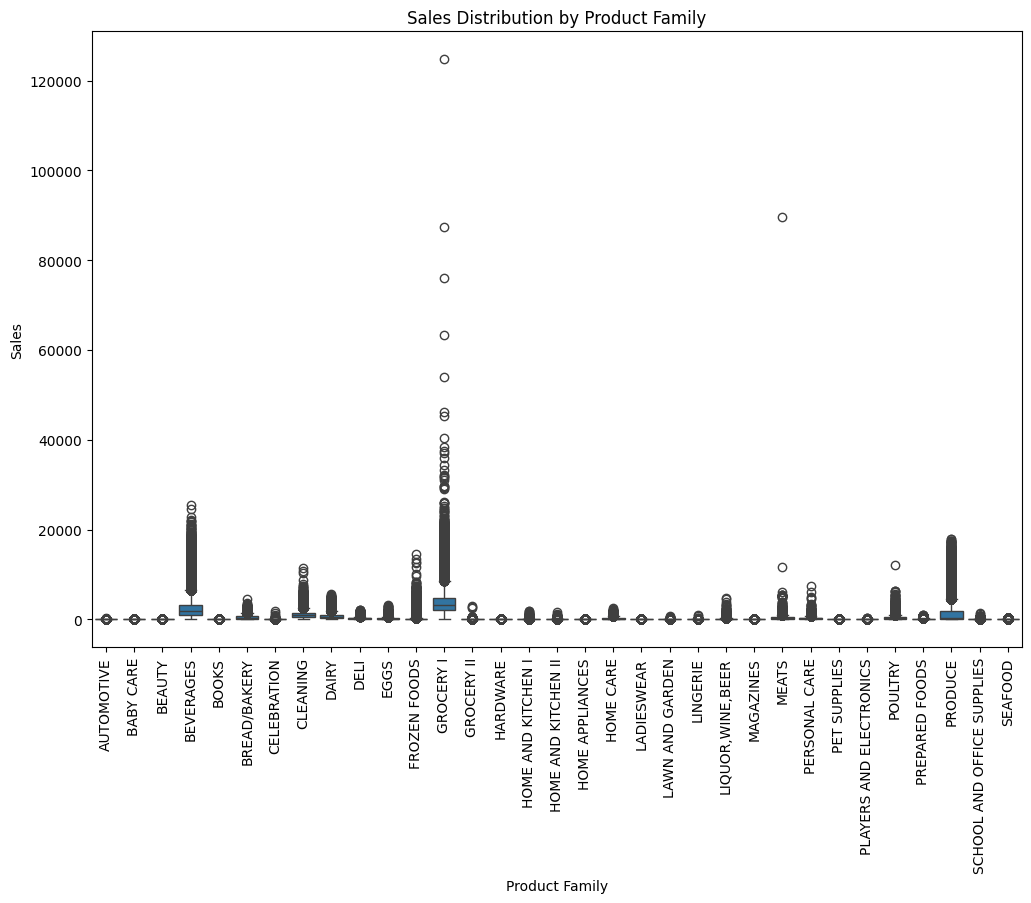

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='family', y='sales', data=final_merged_data)
plt.title('Sales Distribution by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()


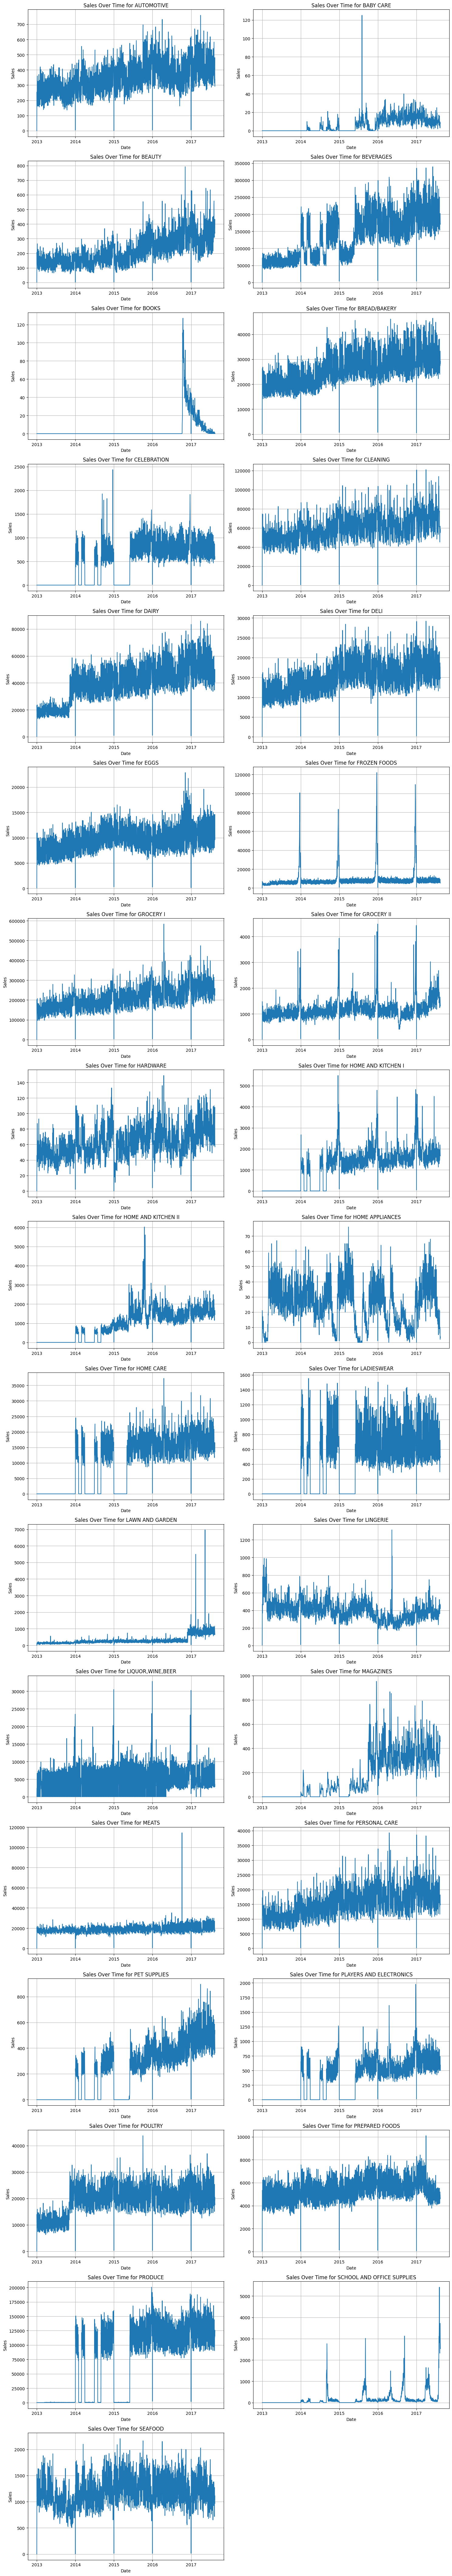

In [ ]:
# Group the data by 'date' and 'family' and calculate the total sales for each group
sales_by_family_time = final_merged_data.groupby(['date', 'family'])['sales'].sum().reset_index()

# Get unique families
unique_families = sales_by_family_time['family'].unique()

# Create subplots
num_rows = (len(unique_families) + 1) // 2  # Calculate number of rows for subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Plot each family in a separate subplot
for i, family in enumerate(unique_families):
    family_data = sales_by_family_time[sales_by_family_time['family'] == family]
    axes[i].plot(family_data['date'], family_data['sales'])
    axes[i].set_title(f'Sales Over Time for {family}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Model processing

In [265]:
from sklearn.preprocessing import MinMaxScaler

# Replace zero sales with a small value to avoid AIC inf
small_value = 0.001
train_df['sales'] = train_df['sales'].replace(0, small_value)

# Apply MinMaxScaler to scale the sales data
scaler = MinMaxScaler()
train_df['scaled_sales'] = scaler.fit_transform(train_df[['sales']])



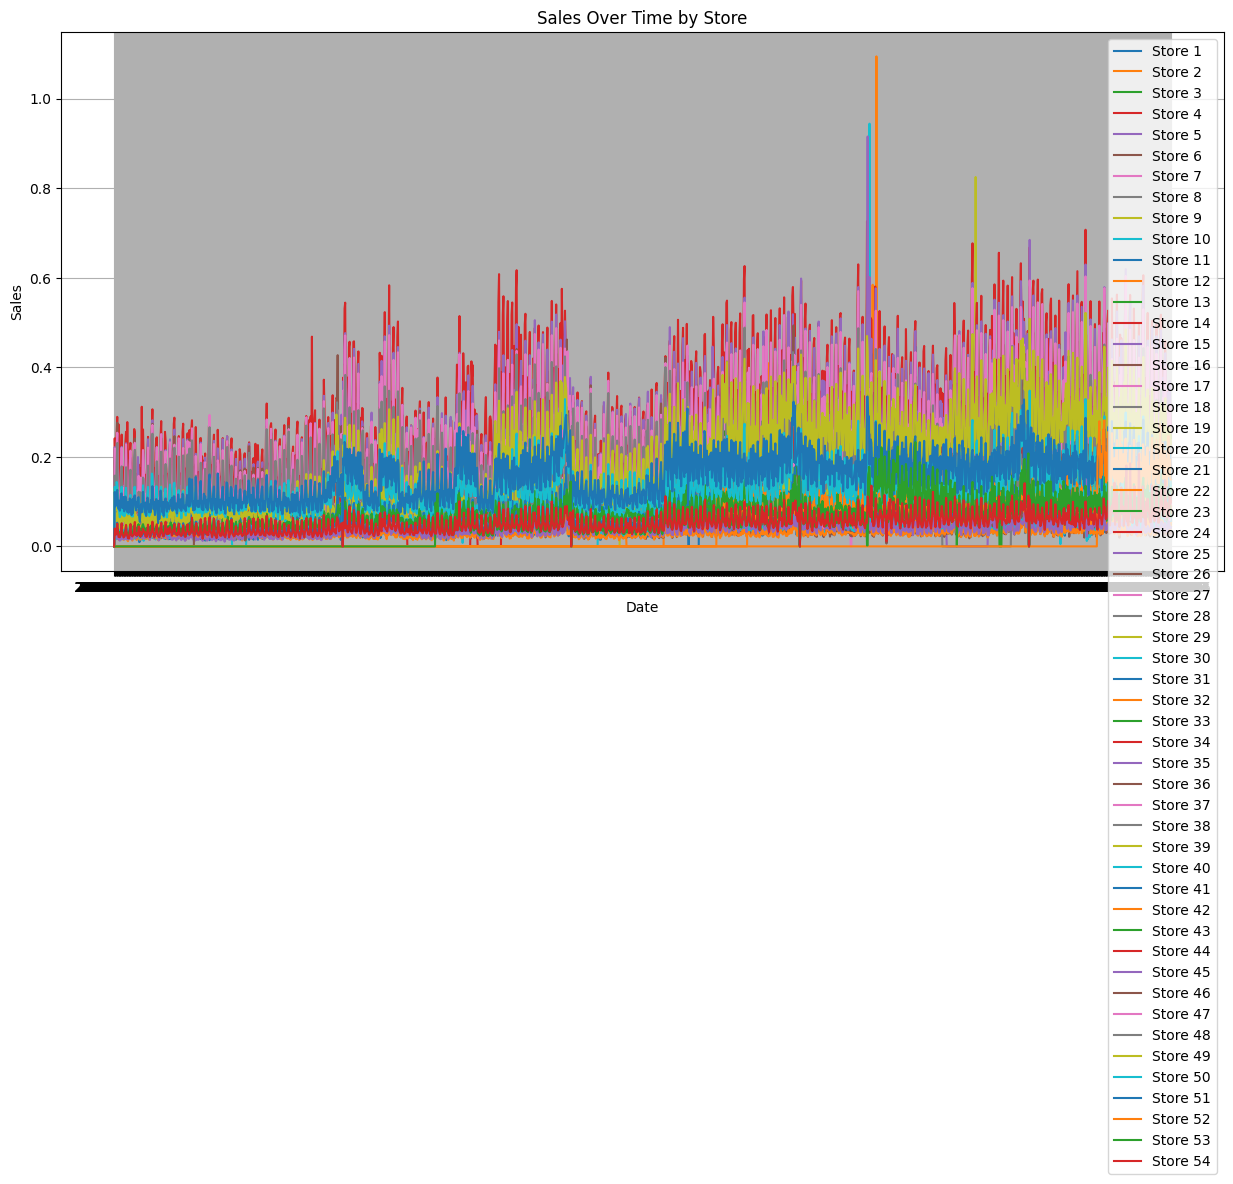

In [266]:
#after scaled
sales_by_store_scaled = train_df.groupby(['date', 'store_nbr'])['scaled_sales'].sum().reset_index()

# Plot sales for a few stores
plt.figure(figsize=(15, 7))
for store in sales_by_store_scaled['store_nbr'].unique():
    store_data = sales_by_store_scaled[sales_by_store_scaled['store_nbr'] == store]
    plt.plot(store_data['date'], store_data['scaled_sales'], label=f'Store {store}')

plt.title('Sales Over Time by Store')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


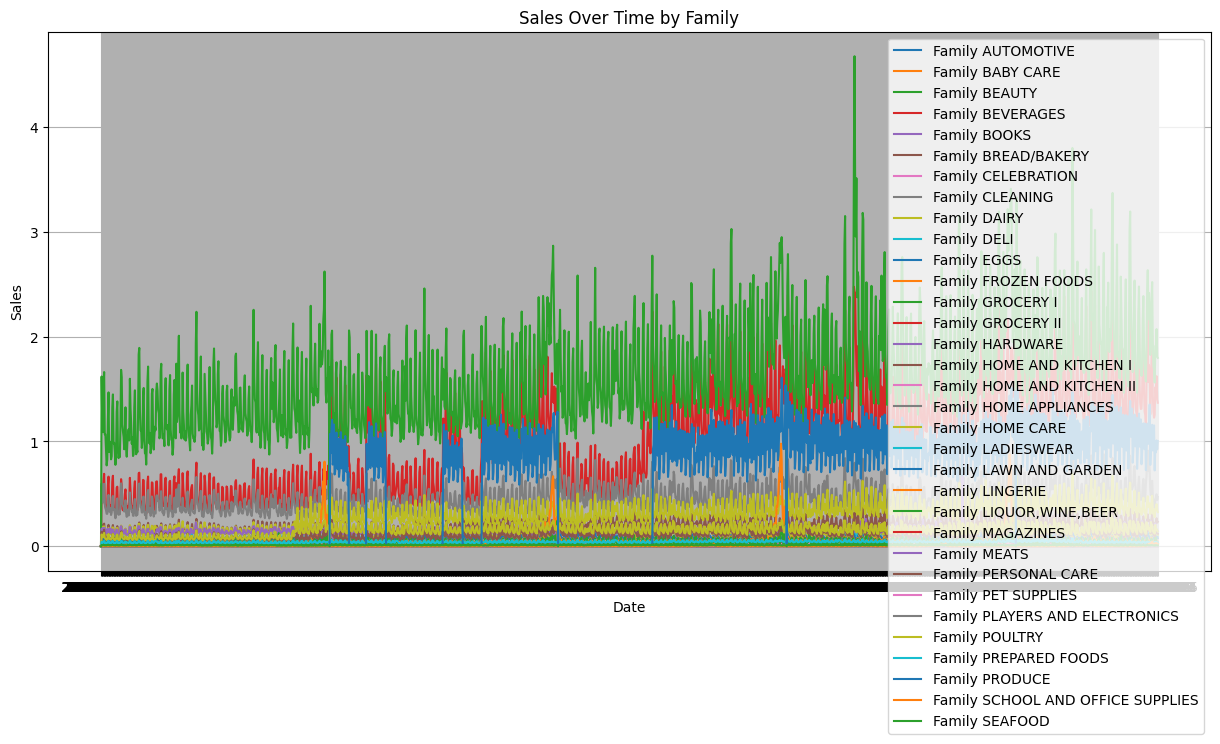

In [267]:
#after smoothing
sales_by_family_scaled = train_df.groupby(['date', 'family'])['scaled_sales'].sum().reset_index()

# Plot sales for a few family
plt.figure(figsize=(15, 7))
for family in sales_by_family_scaled['family'].unique():
    family_data = sales_by_family_scaled[sales_by_family_scaled['family'] == family]
    plt.plot(family_data['date'], family_data['scaled_sales'], label=f'Family {family}')

plt.title('Sales Over Time by Family')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [268]:
# Convert 'date' to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Extract year, month, day, and other date features
for df in [train_df, test_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week

# Fourier terms for capturing seasonality
def create_fourier_terms(df, period, order):
    t = np.arange(len(df))
    for i in range(1, order + 1):
        df[f'sin_{i}'] = np.sin(2 * np.pi * i * t / period)
        df[f'cos_{i}'] = np.cos(2 * np.pi * i * t / period)
    return df

# Apply Fourier terms to train and test data
train_df = create_fourier_terms(train_df, period=365.25, order=3)
test_df = create_fourier_terms(test_df, period=365.25, order=3)


In [269]:
from sklearn.preprocessing import OneHotEncoder

# OneHotEncoding for 'family' column
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform 'family' column for both train and test
train_encoded = encoder.fit_transform(train_df[['family']])
test_encoded = encoder.transform(test_df[['family']])

# Add the encoded columns to train and test data
family_encoded_cols = encoder.get_feature_names_out(['family'])
train_df[family_encoded_cols] = train_encoded
test_df[family_encoded_cols] = test_encoded


In [270]:
# Create lag features grouped by both family and store_nbr
def create_lag_features(df, lag_days):
    for lag in lag_days:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['scaled_sales'].shift(lag)
    return df

# Apply lag features (1-day, 3-day, and 7-day lags)
train_df = create_lag_features(train_df, lag_days=[1, 3, 7])

# Fill NA values that come from lagging
train_df.fillna(0, inplace=True)

# Add rolling mean and rolling standard deviation
train_df['rolling_mean_7'] = train_df.groupby(['store_nbr', 'family'])['scaled_sales'].shift(1).rolling(window=7).mean()
train_df['rolling_std_7'] = train_df.groupby(['store_nbr', 'family'])['scaled_sales'].shift(1).rolling(window=7).std()

train_df['rolling_mean_14'] = train_df.groupby(['store_nbr', 'family'])['scaled_sales'].shift(1).rolling(window=14).mean()
train_df['rolling_std_14'] = train_df.groupby(['store_nbr', 'family'])['scaled_sales'].shift(1).rolling(window=14).std()

train_df['rolling_mean_30'] = train_df.groupby(['store_nbr', 'family'])['scaled_sales'].shift(1).rolling(window=30).mean()
train_df['rolling_std_30'] = train_df.groupby(['store_nbr', 'family'])['scaled_sales'].shift(1).rolling(window=30).std()


# Fill NA values in rolling calculations
train_df.fillna(0, inplace=True)

# Drop the original 'family' column from train and test datasets
train_df = train_df.drop('family', axis=1)
test_df = test_df.drop('family', axis=1)


In [271]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb

# Split the data into training and validation sets (80% train, 20% validation)
split_point = int(len(train_df) * 0.8)

# Drop 'scaled_sales' as it's the target variable
X_train = train_df.iloc[:split_point].drop(['sales'], axis=1)
y_train = train_df.iloc[:split_point]['scaled_sales']
X_val = train_df.iloc[split_point:].drop(['sales'], axis=1)
y_val = train_df.iloc[split_point:]['scaled_sales']


In [272]:
# ---- Model 1: ARIMA ----

train_combined = X_train.copy()
train_combined['scaled_sales'] = y_train

# Aggregate sales at daily level
daily_sales_train = train_combined.groupby('date')['scaled_sales'].sum().reset_index()

# Fit ARIMA model
arima_model = ARIMA(daily_sales_train['scaled_sales'], order=(1, 1, 1))
arima_result = arima_model.fit()

# Prepare validation set similarly (combine X_val and y_val for ARIMA validation)
val_combined = X_val.copy()
val_combined['scaled_sales'] = y_val

# Aggregate sales for validation
daily_sales_val = val_combined.groupby('date')['scaled_sales'].sum().reset_index()

# Predict on validation set using ARIMA
arima_forecast = arima_result.forecast(steps=len(daily_sales_val))

# Handle potential negative values in predictions
arima_forecast = np.maximum(arima_forecast, 0)  # Set negative predictions to 0

# Compute RMSE for ARIMA
rmsle_arima = np.sqrt(mean_squared_log_error(daily_sales_val['scaled_sales'], arima_forecast))
print(f"RMSLE for ARIMA: {rmsle_arima}")


RMSLE for ARIMA: 0.2451436014646982


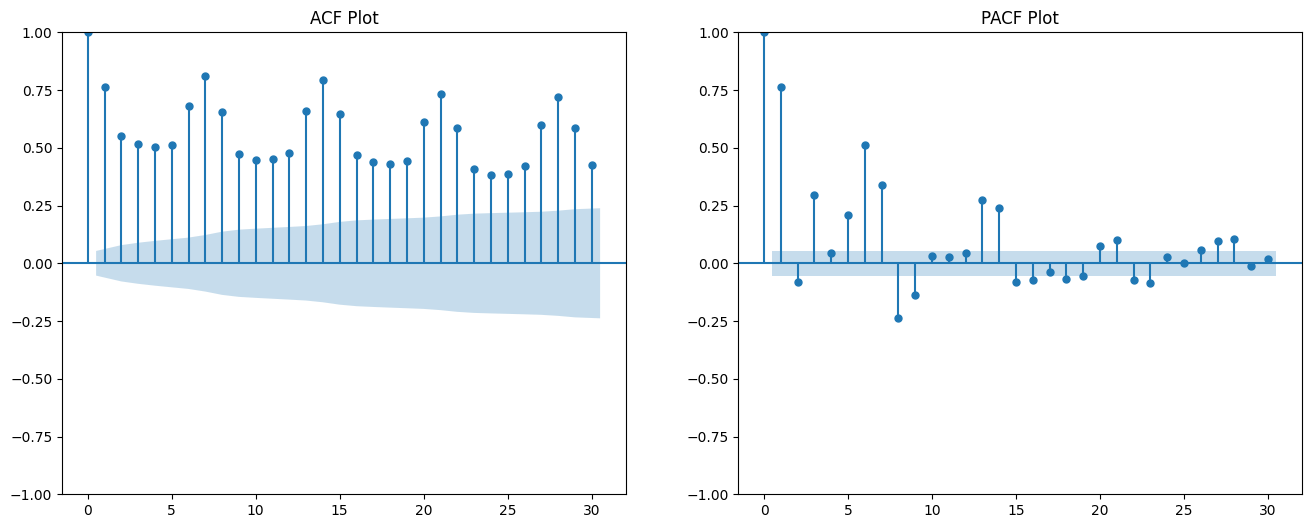

In [273]:
#--- Pre SARIMA model ---

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the training data
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF plot
plot_acf(daily_sales_train['scaled_sales'], lags=30, ax=axes[0])
axes[0].set_title('ACF Plot')

# PACF plot
plot_pacf(daily_sales_train['scaled_sales'], lags=30, ax=axes[1])
axes[1].set_title('PACF Plot')

plt.show()


In [274]:
from statsmodels.tsa.stattools import adfuller

# Perform seasonal differencing with lag 12 for monthly data
diff_sales = daily_sales_train['scaled_sales'].diff(12).dropna()

# Perform the ADF test
adf_test = adfuller(diff_sales)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')


ADF Statistic: -11.309225625545826
p-value: 1.2509938031703447e-20


In [275]:
# ---- Model 2: SARIMA ----

import itertools

# Define ranges for p, d, q parameters
p = q = range(0, 2)
d = range(0, 2)

# Define ranges for seasonal P, D, Q, s parameters (seasonality: 12 months)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Assuming train_combined is available in this scope (if not, you need to define or import it)
train_combined = X_train.copy()
train_combined['scaled_sales'] = y_train

# Aggregate sales at daily level
daily_sales_train = train_combined.groupby('date')['scaled_sales'].sum().reset_index()

best_aic = float("inf")
best_order = None
best_seasonal_order = None

# Perform Grid Search over a reduced set of parameters
for param in itertools.product(p, d, q):
    for param_seasonal in seasonal_pdq:
        try:
            # SARIMA model with fewer iterations to avoid crashing
            model = SARIMAX(daily_sales_train['scaled_sales'],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(maxiter=50, disp=False)

            # Check if the current model is better than the best one
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
        except Exception as e:
            print(f"Error with parameters {param}, {param_seasonal}: {e}")
            continue

print(f'Best SARIMA Model: ARIMA{best_order}x{best_seasonal_order}12 - AIC:{best_aic}')

# Refit SARIMA with the best parameters
sarima_model = SARIMAX(daily_sales_train['scaled_sales'],
                       order=best_order,
                       seasonal_order=best_seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit(maxiter=100, disp=False)

# Predict on the validation set
sarima_forecast = sarima_result.forecast(steps=len(X_val))

# Ensure no negative values for RMSLE and clip y_val
sarima_forecast[sarima_forecast < 0] = 0
y_val_clipped = np.clip(y_val, a_min=0, a_max=None)

# Compute RMSLE for SARIMA
rmsle_sarima = np.sqrt(mean_squared_log_error(y_val_clipped, sarima_forecast))
print(f"RMSLE for SARIMA: {rmsle_sarima}")


Best SARIMA Model: ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:3707.33695724917
RMSLE for SARIMA: 1.8835898494080305


In [276]:
# ---- Model 3: XGBoost ----
from sklearn.model_selection import GridSearchCV

X_train_xgb = X_train.drop('date', axis=1)
X_val_xgb = X_val.drop('date', axis=1)

# Grid search parameters
params = {
    'learning_rate': [0.01],
    'max_depth': [5],
    'n_estimators': [300]}

# Initialize XGBoost
xgb_model = xgb.XGBRegressor()

# GridSearch for tuning - Use 'neg_mean_squared_log_error'
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params,
                           scoring='neg_mean_squared_log_error', cv=3)
grid_search.fit(X_train_xgb, y_train)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Predict on validation set
xgb_forecast = best_xgb_model.predict(X_val_xgb)

# Ensure no negative values for RMSLE and clip y_val
xgb_forecast[xgb_forecast < 0] = 0
y_val_clipped = np.clip(y_val, a_min=0, a_max=None)

# Compute RMSLE for XGBoost
rmsle_xgb = np.sqrt(mean_squared_log_error(y_val_clipped, xgb_forecast))
print(f"Tuned XGBoost RMSLE: {rmsle_xgb}")
print(f"Best Parameters: {grid_search.best_params_}")


Tuned XGBoost RMSLE: 0.0016209808884584996
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}


In [277]:
#--- Model 4: LightGBM ---
from lightgbm import LGBMRegressor

# Replace special characters in column names (if not already done)
X_train_xgb = X_train_xgb.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_val_xgb = X_val_xgb.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# LightGBM Grid search parameters (adjusted)
lgb_params = {
    'learning_rate': [0.01],
    'max_depth': [7],
    'n_estimators': [300],
    'min_data_in_leaf': [70] }

# Initialize LightGBM model
lgb_model = LGBMRegressor()

# GridSearchCV for tuning
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=lgb_params,
                               scoring='neg_mean_squared_log_error', cv=3)
grid_search_lgb.fit(X_train_xgb, y_train)

# Get the best LightGBM model
best_lgb_model = grid_search_lgb.best_estimator_

# Predict on validation set
lgb_forecast = best_lgb_model.predict(X_val_xgb)

# Ensure no negative values and clip y_val
lgb_forecast[lgb_forecast < 0] = 0
y_val_clipped = np.clip(y_val, a_min=0, a_max=None)

# Compute RMSLE for LightGBM
rmsle_lgb = np.sqrt(mean_squared_log_error(y_val_clipped, lgb_forecast))
print(f"Tuned LightGBM RMSLE: {rmsle_lgb}")
print(f"Best Parameters: {grid_search_lgb.best_params_}")


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5022
[LightGBM] [Info] Number of data points in the train set: 1600473, number of used features: 58
[LightGBM] [Info] Start training from score 0.003004
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: mi

In [278]:
#--- Model 5: CatBoost ---
from catboost import CatBoostRegressor

# CatBoost Grid search parameters
cat_params = {
    'learning_rate': [0.01],
    'depth': [9],
    'iterations': [300]}

# Initialize CatBoost model
cat_model = CatBoostRegressor(verbose=0)

# GridSearchCV for tuning
grid_search_cat = GridSearchCV(estimator=cat_model, param_grid=cat_params,
                               scoring='neg_mean_squared_log_error', cv=3)
grid_search_cat.fit(X_train_xgb, y_train)

# Get the best CatBoost model
best_cat_model = grid_search_cat.best_estimator_

# Predict on validation set
cat_forecast = best_cat_model.predict(X_val_xgb)

# Ensure no negative values and clip y_val
cat_forecast[cat_forecast < 0] = 0
y_val_clipped = np.clip(y_val, a_min=0, a_max=None)

# Compute RMSLE for CatBoost
rmsle_cat = np.sqrt(mean_squared_log_error(y_val_clipped, cat_forecast))
print(f"Tuned CatBoost RMSLE: {rmsle_cat}")
print(f"Best Parameters: {grid_search_cat.best_params_}")


Tuned CatBoost RMSLE: 0.0015112499166450178
Best Parameters: {'depth': 9, 'iterations': 300, 'learning_rate': 0.01}


In [288]:
# Load train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Add a 'source' column to distinguish between train and test in the combined data
train['source'] = 'train'
test['source'] = 'test'

# Convert 'date' to datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# Drop 'id' from both train and test data
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

# Replace zero sales with a small value (0.001)
small_value = 0.001
train['sales'] = train['sales'].replace(0, small_value)

# Add a placeholder 'sales' column to the test data so we can combine datasets
test['sales'] = np.nan  # Test sales are unknown

# Combine train and test datasets
combined_df = pd.concat([train, test], axis=0)

# Extract year, month, and day for combined data
combined_df['year'] = combined_df['date'].dt.year
combined_df['month'] = combined_df['date'].dt.month
combined_df['day'] = combined_df['date'].dt.day
combined_df['day_of_week'] = combined_df['date'].dt.dayofweek
combined_df['day_of_year'] = combined_df['date'].dt.dayofyear
combined_df['week_of_year'] = combined_df['date'].dt.isocalendar().week

# Fourier terms for capturing seasonality
def create_fourier_terms(df, period, order):
    t = np.arange(len(df))
    for i in range(1, order + 1):
        df[f'sin_{i}'] = np.sin(2 * np.pi * i * t / period)
        df[f'cos_{i}'] = np.cos(2 * np.pi * i * t / period)
    return df

# Apply Fourier terms for seasonality
combined_df = create_fourier_terms(combined_df, period=365.25, order=3)

# OneHotEncoding for 'family'
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform on the combined 'family' column
encoded_family = encoder.fit_transform(combined_df[['family']])

# Add the encoded columns back to the combined dataset
family_encoded_cols = encoder.get_feature_names_out(['family'])
family_encoded_cols = [col.replace('[', '_').replace(']', '_') for col in family_encoded_cols]  # Replace special characters
combined_df[family_encoded_cols] = encoded_family

# Apply MinMaxScaler to the 'sales' column
scaler = MinMaxScaler()
combined_df['scaled_sales'] = scaler.fit_transform(combined_df[['sales']])

# Create lag features for the combined data (ensure consistent lag features for both train and test)
def create_lag_features(df, lag_days):
    for lag in lag_days:
        df[f'sales_lag_{lag}'] = df.groupby('store_nbr')['scaled_sales'].shift(lag)
    return df

# Apply lag features (1-day and 7-day lags) to both train and test
combined_df = create_lag_features(combined_df, lag_days=[1, 7])

# Add rolling mean and rolling standard deviation for 7-day and 14-day windows
combined_df['rolling_mean_7'] = combined_df.groupby('store_nbr')['scaled_sales'].shift(1).rolling(window=7).mean()
combined_df['rolling_std_7'] = combined_df.groupby('store_nbr')['scaled_sales'].shift(1).rolling(window=7).std()
combined_df['rolling_mean_14'] = combined_df.groupby('store_nbr')['scaled_sales'].shift(1).rolling(window=14).mean()
combined_df['rolling_std_14'] = combined_df.groupby('store_nbr')['scaled_sales'].shift(1).rolling(window=14).std()
combined_df['rolling_mean_30'] = combined_df.groupby('store_nbr')['scaled_sales'].shift(1).rolling(window=30).mean()
combined_df['rolling_std_30'] = combined_df.groupby('store_nbr')['scaled_sales'].shift(1).rolling(window=30).std()

#Drop family column
combined_df = combined_df.drop('family', axis=1)

# Fill NA values in rolling calculations
combined_df.fillna(0, inplace=True)

# Make sure to apply the same transformations to both train and test datasets
train_processed = combined_df[combined_df['source'] == 'train'].drop(['source', 'date'], axis=1)
test_processed = combined_df[combined_df['source'] == 'test'].drop(['source', 'date', 'sales'], axis=1)

# Prepare train and test datasets for modeling, EXCLUDING 'sales' from features
X_train = train_processed.drop(['sales', 'scaled_sales'], axis=1)
y_train = train_processed['scaled_sales']
X_test = test_processed.drop(['scaled_sales'], axis=1)

# Replace special characters in column names (if not already done)
X_train = X_train.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
X_test = X_test.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))

# Initialize and train the LightGBM model with the best parameters
lgb_model = LGBMRegressor(
    learning_rate=0.01,
    max_depth=7,
    min_data_in_leaf=70,
    n_estimators=300)

# Train the model on the processed training data
lgb_model.fit(X_train, y_train)

# Predict on the processed test data
test_forecast_scaled = lgb_model.predict(X_test)

# Ensure no negative values in predictions
test_forecast_scaled[test_forecast_scaled < 0] = 0

# Inverse transform the scaled predictions back to their original scale
test_forecast = scaler.inverse_transform(test_forecast_scaled.reshape(-1, 1)).flatten()

# Output the predictions for the test set
print(test_forecast)


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4259
[LightGBM] [Info] Number of data points in the train set: 3000888, number of used features: 55
[LightGBM] [Info] Start training from score 0.002869
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[ 84.51244488  41.49193226 161.46809568 ... 284.83861988 225.37213784
  42.93557163]


In [289]:
submission = pd.DataFrame({'id': test_df['id'], 'sales': test_forecast})
submission['sales'] = submission['sales'].round(3)
submission.to_csv('submission3.csv', index=False)


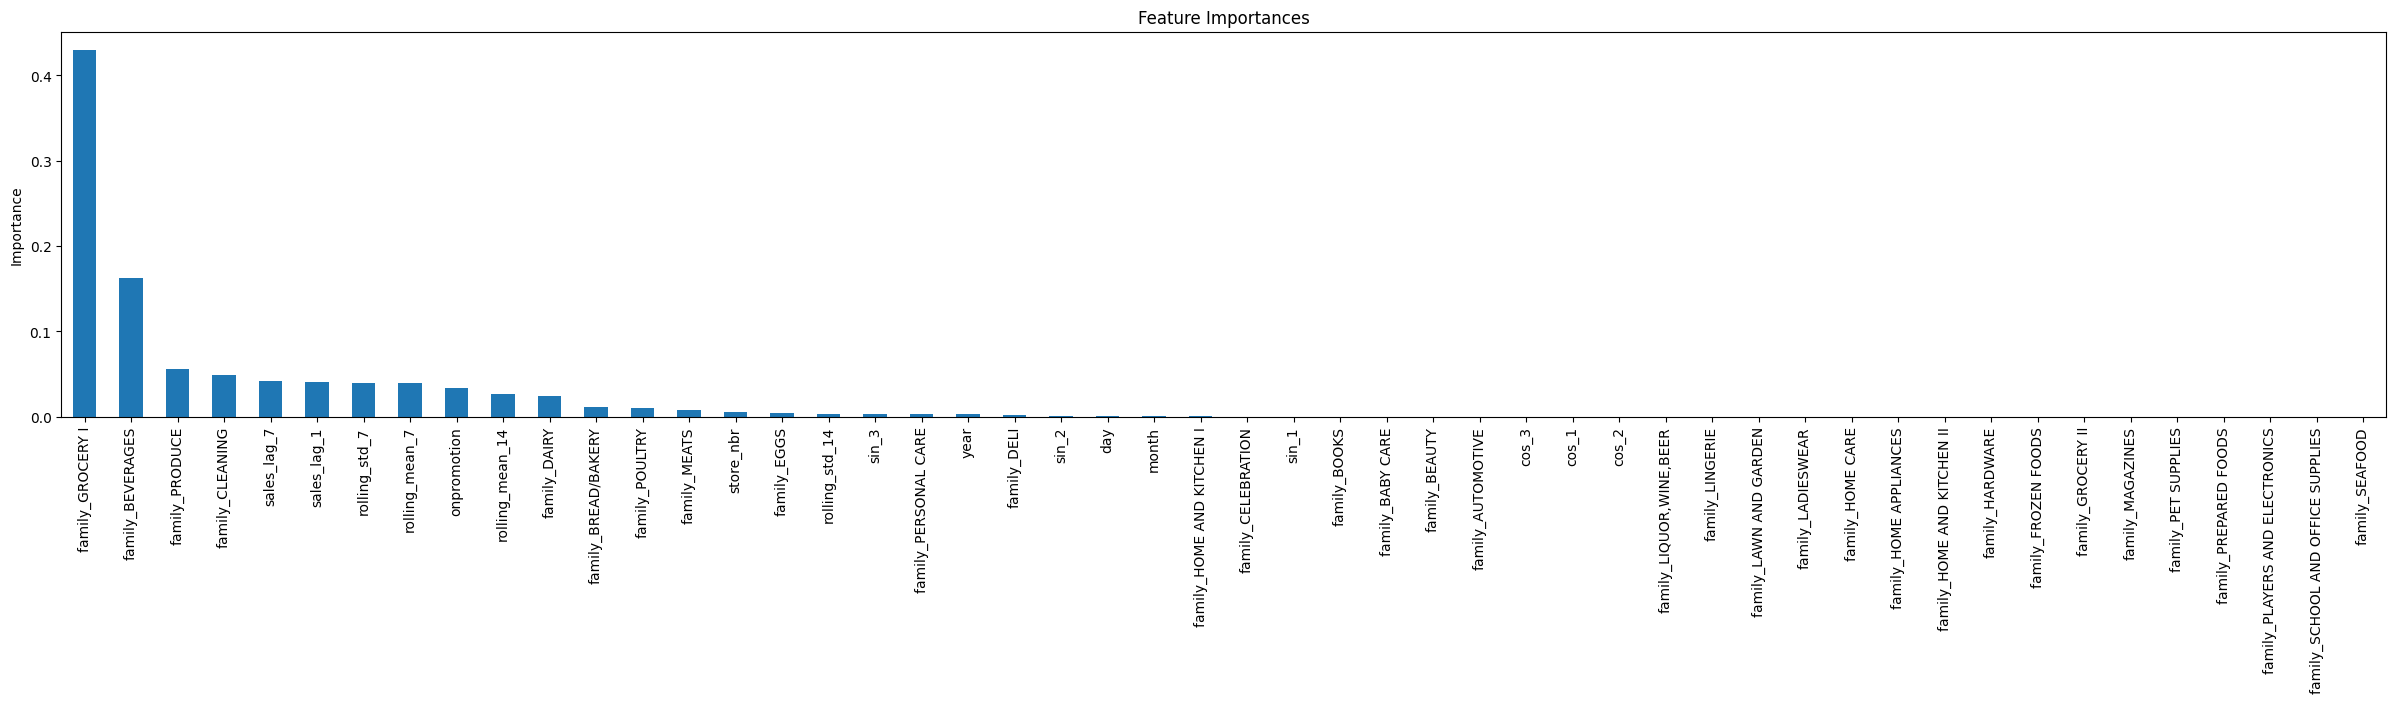

In [56]:
# Get feature importances
importances = xgb_model.feature_importances_

# Create a Series for easier visualization
feature_importances = pd.Series(importances, index=X_train_xgb.columns)

# Sort and plot
plt.figure(figsize=(30, 5))
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint